In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

#### **Part I** demand simulation

In [28]:
## X_ijt = λ_0 + λ_1*X_ijt-1 + λ_2*age_i + λ_3*female_i + λ_4*income_i + λ_5*avg. temp_t + λ_6*cpi_t + e_ijt
## temp

#### generate temp and CPI data

In [2]:
def gen_macro_df(days, cpi_low, cpi_high, temp_low, temp_high, rainfall_low, rainfall_high):    
    # Step 1: Generate dates spanning 6 months to today
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days)  # Approximate 6 months as 180 days
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Step 2: Generate temperature values with increasing trend and random noise
    np.random.seed(0)  # For reproducibility
    num_days = len(dates)
    temperature_base = np.linspace(temp_low, temp_high, num_days)  # Base temperature increasing linearly from 20 to 30
    temperature_noise = np.random.normal(0, 5, num_days)  # Adding random noise with mean 0 and std deviation 2
    temperatures = np.round(temperature_base + temperature_noise, 2)
    
    rainfall_base = np.linspace(rainfall_low, rainfall_high, num_days)  # Base temperature increasing linearly from 20 to 30
    rainfall_noise = np.random.normal(0, 5, num_days)  # Adding random noise with mean 0 and std deviation 2
    rainfalls = np.round(rainfall_base + rainfall_noise, 2)
    rainfalls = np.where(rainfalls<0, 0, rainfalls)

    # Step 3: Generate CPI values that vary each month with random noise
    months = pd.date_range(start=start_date, end=end_date, freq='M')
    cpi_base = np.linspace(cpi_low, cpi_high, len(months))  # Base CPI increasing linearly from 100 to 105
    cpi_noise = np.random.normal(0, 1, len(months))  # Adding random noise with mean 0 and std deviation 1
    cpi_values = np.round(cpi_base + cpi_noise, 2)
    
    # Create a DataFrame with dates and temperatures
    df = pd.DataFrame({'Date': dates, 'Temperature': temperatures, 'Rainfall': rainfalls})
    
    # Assign CPI values to the first day of each month, and forward fill the rest of the days in the month
    cpi_series = pd.Series(cpi_values, index=months)
    
    # Ensure the CPI series starts from the first date in the DataFrame
    cpi_series = cpi_series.reindex(dates, method='ffill').fillna(method='bfill')
    
    # Assign the CPI values to the DataFrame
    df['CPI'] = cpi_series.values
    
    # Fix the date format to 'YYYY-MM-DD'
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    return df
    
df_macro = gen_macro_df(days=180, cpi_low=100, cpi_high=105, temp_low=40, temp_high=80, rainfall_low=0, rainfall_high=200)

#### generate customer data

In [4]:
def gen_cust_df(n_customers, income_mean, income_std):    
    # Number of customers
    n_customers = n_customers
    
    # Generate customer IDs
    customer_ids = np.arange(1, n_customers + 1)
    
    # Generate random values for female
    np.random.seed(0)  # For reproducibility
    female = np.random.choice([0, 1], size=n_customers)
    
    # Generate random values for age (between 18 and 70)
    age = np.random.randint(18, 71, size=n_customers)
    
    # Generate random values for income (normal distribution with mean 50k and std deviation 15k)
    income = np.random.normal(income_mean, income_std, size=n_customers)
    income = np.round(income, 2)  # Round to 2 decimal places
    
    # Create a DataFrame with the generated data
    data = pd.DataFrame({
        'CustomerID': customer_ids,
        'Female': female,
        'Age': age,
        'Income': income
    })
    
    return data

df_customer = gen_cust_df(n_customers=100, income_mean=50000, income_std=30000)

#### generate order data

In [23]:
n_customers = 100
n_products = 4
n_days = 180

# Create order quantities for date, customer, and product combination
order_quantities = np.random.randint(0, 10, size=(n_customers, n_products, n_days))

# Create a meshgrid for customer IDs, product IDs, and days
customers = np.arange(n_customers) + 1
products = np.arange(n_products) + 1
# days = np.arange(n_days)
end_date = datetime.today()
start_date = end_date - timedelta(days=n_days-1)  # Approximate 6 months as 180 days
dates = pd.date_range(start=start_date, end=end_date, freq='D')

customers_grid, products_grid, dates_grid = np.meshgrid(customers, products, dates, indexing='ij')

df_orders = pd.DataFrame({
    'CustomerID': customers_grid.flatten(),
    'ProductID': products_grid.flatten(),
    'Date': dates_grid.flatten(),
    'OrderQuantity': order_quantities.flatten()
})

df_orders['OrderQuantity'] = np.where(df_orders['Date']==df_orders['Date'].min(), df_orders['OrderQuantity'], 0)
df_orders.sort_values(by=['CustomerID', 'ProductID', 'Date'], inplace=True)
df_orders['OrderQuantity_lag1'] = df_orders.groupby(['CustomerID', 'ProductID'])['OrderQuantity'].shift(1)
df_orders['Date'] = df_orders['Date'].dt.strftime('%Y-%m-%d')
df_orders['Day'] = df_orders['Date'].rank(method='dense').astype(int)

df_orders

,CustomerID,ProductID,Date,OrderQuantity,OrderQuantity_lag1,Day
0,1,1,2023-12-20,8,NaN,1
1,1,1,2023-12-21,0,8.0,2
2,1,1,2023-12-22,0,0.0,3
3,1,1,2023-12-23,0,0.0,4
4,1,1,2023-12-24,0,0.0,5
...,...,...,...,...,...,...
71995,100,4,2024-06-12,0,0.0,176
71996,100,4,2024-06-13,0,0.0,177
71997,100,4,2024-06-14,0,0.0,178
71998,100,4,2024-06-15,0,0.0,179


In [24]:
df = df_orders.merge(df_macro, on='Date', how='left')
df = df.merge(df_customer, on='CustomerID', how='left')
df

,CustomerID,ProductID,Date,OrderQuantity,OrderQuantity_lag1,Day,Temperature,Rainfall,CPI,Female,Age,Income
0,1,1,2023-12-20,8,NaN,1,42.22,0.00,100.93,0,60,59662.22
1,1,1,2023-12-21,0,8.0,2,45.34,0.00,100.93,0,60,59662.22
2,1,1,2023-12-22,0,0.0,3,51.87,6.46,100.93,0,60,59662.22
3,1,1,2023-12-23,0,0.0,4,50.23,0.00,100.93,0,60,59662.22
4,1,1,2023-12-24,0,0.0,5,36.22,0.03,100.93,0,60,59662.22
...,...,...,...,...,...,...,...,...,...,...,...,...
71995,100,4,2024-06-12,0,0.0,176,75.09,193.17,104.61,0,70,47499.86
71996,100,4,2024-06-13,0,0.0,177,75.89,194.27,104.61,0,70,47499.86
71997,100,4,2024-06-14,0,0.0,178,77.28,200.88,104.61,0,70,47499.86
71998,100,4,2024-06-15,0,0.0,179,79.87,202.38,104.61,0,70,47499.86


In [59]:
coef_true = {'intercept': np.random.normal(size=n_products),
            'OrderQuantity_lag1': np.random.normal(size=n_products),
            'Female': np.random.normal(size=n_products),
            'Age': 0.2*np.random.normal(size=n_products),
            'Income': 0.0003*np.random.normal(size=n_products),
            'Temperature': 0.1*np.random.normal(size=n_products),
            'Rainfall': 0.01*np.random.normal(size=n_products),
            'CPI': 0.01*np.random.normal(size=n_products)
            }
coef_true

{'intercept': array([ 0.84371213, -1.82600287, -0.80457644,  0.67660084]),
 'OrderQuantity_lag1': array([-0.96737703, -0.36378864, -2.20204603,  2.66949948]),
 'Female': array([-1.72529748,  0.66203517,  0.64953487,  0.84242769]),
 'Age': array([0.17814914, 0.08605205, 0.10561327, 0.08178627]),
 'Income': array([-7.46081700e-06,  7.64230877e-04, -3.02840549e-04, -1.69738862e-04]),
 'Temperature': array([ 0.20144277,  0.08165895, -0.19895766, -0.19086549]),
 'Rainfall': array([ 0.02237453, -0.00812742, -0.00193303, -0.01169957]),
 'CPI': array([-0.01175576,  0.01201877, -0.01512153,  0.00459418])}

In [62]:
def gen_next_product_quantity(df1):
    df1 = df1.sort_values(by='Date', ascending=True)
    df1.reset_index(inplace=True)
    df1.drop(['index'], axis=1, inplace=True)

    for j in range(1, n_days):
        df1.at[j, 'OrderQuantity'] = np.dot([coef_true['intercept'][i-1], coef_true['OrderQuantity_lag1'][i-1], coef_true['Female'][i-1], coef_true['Age'][i-1], coef_true['Income'][i-1], coef_true['Temperature'][i-1], coef_true['Rainfall'][i-1], coef_true['CPI'][i-1]]
                                    , [1, df1.at[j, 'OrderQuantity_lag1'], df1.at[j, 'Female'], df1.at[j, 'Age'], df1.at[j, 'Income'], df1.at[j, 'Temperature'], df1.at[j, 'Rainfall'], df1.at[j, 'CPI']])
        df1.at[j+1, 'OrderQuantity_lag1'] = df1.at[j, 'OrderQuantity']
    return df1

df = df.groupby(['CustomerID', 'ProductID']).apply(gen_next_product_quantity)

In [66]:
df_1_1 = df[(df['CustomerID']==1) & (df['ProductID']==1)]
df_1_1

CustomerID  ProductID        Date  OrderQuantity  \
CustomerID ProductID                                                         
1          1         0           1.0        1.0  2023-12-20       8.000000   
                     1           1.0        1.0  2023-12-21      11.295422   
                     2           1.0        1.0  2023-12-22       9.567467   
                     3           1.0        1.0  2023-12-23      10.764145   
                     4           1.0        1.0  2023-12-24       6.784964   
...                              ...        ...         ...            ...   
                     175         1.0        1.0  2024-06-12      11.356387   
                     176         1.0        1.0  2024-06-13      18.506046   
                     177         1.0        1.0  2024-06-14      12.017531   
                     178         1.0        1.0  2024-06-15      18.849670   
                     179         1.0        1.0  2024-06-16      11.857246   

                          OrderQuantity_lag1    Day  Temperature  Rainfall  \
CustomerID ProductID                                                         
1          1         0                   NaN    1.0        42.22      0.00   
                     1              8.000000    2.0        45.34      0.00   
                     2             11.295422    3.0        51.87      6.46   
                     3              9.567467    4.0        50.23      0.00   
                     4             10.764145    5.0        36.22      0.03   
...                                      ...    ...          ...       ...   
                     175           18.555124  176.0        75.09    193.17   
                     176           11.356387  177.0        75.89    194.27   
                     177           18.506046  178.0        77.28    200.88   
                     178           12.017531  179.0        79.87    202.38   
                     179           18.849670  180.0        78.23    200.02   

                             CPI  Female   Age    Income  
CustomerID ProductID                                      
1          1         0    100.93     0.0  60.0  59662.22  
                     1    100.93     0.0  60.0  59662.22  
                     2    100.93     0.0  60.0  59662.22  
                     3    100.93     0.0  60.0  59662.22  
                     4    100.93     0.0  60.0  59662.22  
...                          ...     ...   ...       ...  
                     175  104.61     0.0  60.0  59662.22  
                     176  104.61     0.0  60.0  59662.22  
                     177  104.61     0.0  60.0  59662.22  
                     178  104.61     0.0  60.0  59662.22  
                     179  104.61     0.0  60.0  59662.22  

[180 rows x 12 columns]

In [67]:
df_1_1['OrderQuantity'].describe()

count    180.000000
mean      12.361376
std        4.564754
min        4.354334
25%        8.346011
50%       11.759162
75%       15.998555
max       22.288350
Name: OrderQuantity, dtype: float64

In [69]:
df.to_csv('./data/staged_one_data.csv', index=False)

In [17]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta

# Step 1: Define the true parameters
a_true = 5
b_true = 2
c_true = -3
d_true = 1.5

# Step 2: Generate a date range for the time series data
end_date = datetime.today()
start_date = end_date - timedelta(days=120)  # 100 days of data
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate initial random values for X2 and X3
np.random.seed(0)  # For reproducibility
n_samples = len(dates)
X2 = np.random.rand(n_samples)
X3 = np.random.rand(n_samples)

# Step 3: Compute Y using the true parameters and add random noise
Y_base = a_true + b_true * np.random.rand() + c_true * X2 + d_true * X3  # Initial Y base value
noise = np.random.normal(0, 1, n_samples)
Y = Y_base + noise

# Step 4: Shift Y to create X1 (one-day lag)
X1 = np.roll(Y, 1)
X1[0] = np.nan  # The first value will be NaN due to the shift

# Step 5: Create a DataFrame with the generated data
data = pd.DataFrame({
    'Date': dates,
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'Y': Y
})

# Drop the first row because X1 has a NaN value
data = data.dropna()

# Step 6: Perform regression using statsmodels
# Prepare the data for regression
X = data[['X1', 'X2', 'X3']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = data['Y']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the estimated parameters
a_estimated = model.params['const']
b_estimated = model.params['X1']
c_estimated = model.params['X2']
d_estimated = model.params['X3']

# Step 7: Output the results
print(f"True parameters: a = {a_true}, b = {b_true}, c = {c_true}, d = {d_true}")
print(f"Estimated parameters: a = {a_estimated:.2f}, b = {b_estimated:.2f}, c = {c_estimated:.2f}, d = {d_estimated:.2f}")

# Print the summary of the regression model
print(model.summary())

# Fix the date format to 'YYYY-MM-DD'
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

# Display the DataFrame
print(data.head(10))  # Display the first 10 rows as a sample


True parameters: a = 5, b = 2, c = -3, d = 1.5
Estimated parameters: a = 5.38, b = 0.10, c = -3.06, d = 1.73
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     46.13
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.06e-19
Time:                        22:44:32   Log-Likelihood:                -162.62
No. Observations:                 120   AIC:                             333.2
Df Residuals:                     116   BIC:                             344.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

True parameters: a = 5, b = 2, c = -3
Noisy parameters: a = 5.09, b = 2.02, c = -2.95
Estimated parameters: a = 4.90, b = 1.79, c = -2.56
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     45.41
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.21e-14
Time:                        21:33:38   Log-Likelihood:                -136.81
No. Observations:                 100   AIC:                             279.6
Df Residuals:                      97   BIC:                             287.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

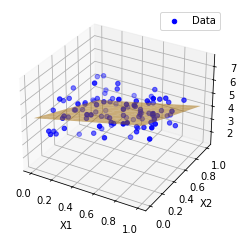

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Generate Fake Data
# Define the true parameters
a_true = 5
b_true = 2
c_true = -3

# Introduce noise to the coefficients
np.random.seed(0)  # For reproducibility
a_noisy = a_true + np.random.normal(0, 0.05)
b_noisy = b_true + np.random.normal(0, 0.05)
c_noisy = c_true + np.random.normal(0, 0.05)

# Number of samples
n_samples = 100

# Generate random values for X1 and X2
X1 = np.random.rand(n_samples)
X2 = np.random.rand(n_samples)

# Generate noise
noise = np.random.normal(0, 1, n_samples)

# Compute Y using noisy coefficients
Y = a_noisy + b_noisy*X1 + c_noisy*X2 + noise

# Create a DataFrame for convenience
data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'Y': Y
})

# Step 2: Perform Regression using statsmodels
# Prepare the data for regression
X = data[['X1', 'X2']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = data['Y']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the estimated parameters
a_estimated = model.params['const']
b_estimated = model.params['X1']
c_estimated = model.params['X2']

print(f"True parameters: a = {a_true}, b = {b_true}, c = {c_true}")
print(f"Noisy parameters: a = {a_noisy:.2f}, b = {b_noisy:.2f}, c = {c_noisy:.2f}")
print(f"Estimated parameters: a = {a_estimated:.2f}, b = {b_estimated:.2f}, c = {c_estimated:.2f}")

# Print the summary of the regression
print(model.summary())

# Plot the data and the regression plane
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['X1'], data['X2'], data['Y'], color='blue', label='Data')

# Create a mesh grid for plotting the regression plane
X1_mesh, X2_mesh = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
Y_mesh = a_estimated + b_estimated*X1_mesh + c_estimated*X2_mesh

# Plot the regression plane
ax.plot_surface(X1_mesh, X2_mesh, Y_mesh, color='orange', alpha=0.5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

plt.show()


True parameters for function 1: a1 = 5, b1 = 2, c1 = -3
Noisy parameters for function 1: a1 = 5.88, b1 = 2.20, c1 = -2.51
Estimated parameters for function 1: a1 = 6.31, b1 = 1.58, c1 = -2.96
True parameters for function 2: a2 = -2, b2 = 4, c2 = 1
Noisy parameters for function 2: a2 = -0.88, b2 = 4.93, c2 = 0.51
Estimated parameters for function 2: a2 = -1.04, b2 = 4.98, c2 = 0.48
                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     52.56
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           3.44e-16
Time:                        21:38:34   Log-Likelihood:                -136.86
No. Observations:                 100   AIC:                             279.7
Df Residuals:                      97   BIC:                   

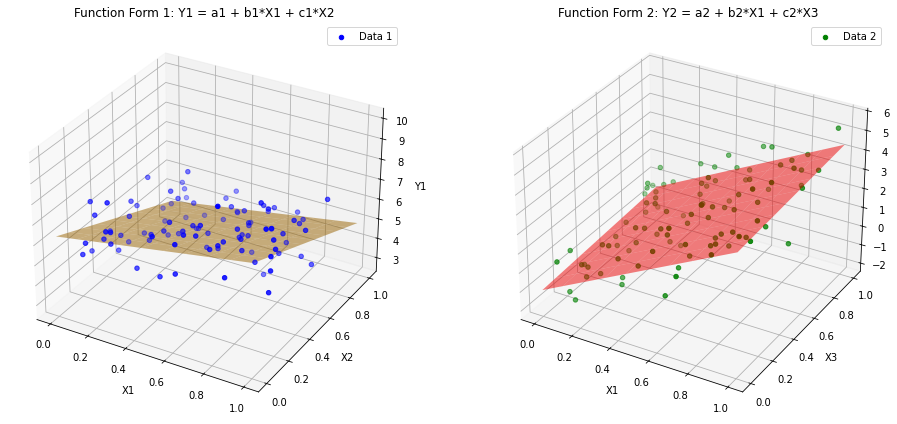

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Define the true parameters
# Function form 1: Y1 = a1 + b1*X1 + c1*X2 + noise1
# Function form 2: Y2 = a2 + b2*X1 + c2*X3 + noise2
a1_true, b1_true, c1_true = 5, 2, -3
a2_true, b2_true, c2_true = -2, 4, 1

# Introduce noise to the coefficients
np.random.seed(0)  # For reproducibility
a1_noisy = a1_true + np.random.normal(0, 0.5)
b1_noisy = b1_true + np.random.normal(0, 0.5)
c1_noisy = c1_true + np.random.normal(0, 0.5)

a2_noisy = a2_true + np.random.normal(0, 0.5)
b2_noisy = b2_true + np.random.normal(0, 0.5)
c2_noisy = c2_true + np.random.normal(0, 0.5)

# Number of samples
n_samples = 100

# Step 2: Generate random values for X1, X2, and X3
X1 = np.random.rand(n_samples)
X2 = np.random.rand(n_samples)
X3 = np.random.rand(n_samples)

# Step 3: Compute Y1 using the first function form with noise
noise1 = np.random.normal(0, 1, n_samples)
Y1 = a1_noisy + b1_noisy*X1 + c1_noisy*X2 + noise1

# Step 4: Compute Y2 using the second function form with noise
noise2 = np.random.normal(0, 1, n_samples)
Y2 = a2_noisy + b2_noisy*X1 + c2_noisy*X3 + noise2

# Create a DataFrame for convenience
data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'Y1': Y1,
    'Y2': Y2
})

# Step 5: Perform Regression for the first function form using statsmodels
# Prepare the data for the first regression
X1_Y1 = data[['X1', 'X2']]
X1_Y1 = sm.add_constant(X1_Y1)
y1 = data['Y1']

# Fit the regression model for the first function form
model1 = sm.OLS(y1, X1_Y1).fit()

# Get the estimated parameters for the first function form
a1_estimated = model1.params['const']
b1_estimated = model1.params['X1']
c1_estimated = model1.params['X2']

print(f"True parameters for function 1: a1 = {a1_true}, b1 = {b1_true}, c1 = {c1_true}")
print(f"Noisy parameters for function 1: a1 = {a1_noisy:.2f}, b1 = {b1_noisy:.2f}, c1 = {c1_noisy:.2f}")
print(f"Estimated parameters for function 1: a1 = {a1_estimated:.2f}, b1 = {b1_estimated:.2f}, c1 = {c1_estimated:.2f}")

# Perform Regression for the second function form using statsmodels
# Prepare the data for the second regression
X2_Y2 = data[['X1', 'X3']]
X2_Y2 = sm.add_constant(X2_Y2)
y2 = data['Y2']

# Fit the regression model for the second function form
model2 = sm.OLS(y2, X2_Y2).fit()

# Get the estimated parameters for the second function form
a2_estimated = model2.params['const']
b2_estimated = model2.params['X1']
c2_estimated = model2.params['X3']

print(f"True parameters for function 2: a2 = {a2_true}, b2 = {b2_true}, c2 = {c2_true}")
print(f"Noisy parameters for function 2: a2 = {a2_noisy:.2f}, b2 = {b2_noisy:.2f}, c2 = {c2_noisy:.2f}")
print(f"Estimated parameters for function 2: a2 = {a2_estimated:.2f}, b2 = {b2_estimated:.2f}, c2 = {c2_estimated:.2f}")

# Print the summary of both regression models
print(model1.summary())
print(model2.summary())

# Plot the data and the regression planes for both function forms
fig = plt.figure(figsize=(14, 6))

# Plot for the first function form
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data['X1'], data['X2'], data['Y1'], color='blue', label='Data 1')
X1_mesh, X2_mesh = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
Y1_mesh = a1_estimated + b1_estimated*X1_mesh + c1_estimated*X2_mesh
ax1.plot_surface(X1_mesh, X2_mesh, Y1_mesh, color='orange', alpha=0.5)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y1')
ax1.legend()
ax1.set_title('Function Form 1: Y1 = a1 + b1*X1 + c1*X2')

# Plot for the second function form
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data['X1'], data['X3'], data['Y2'], color='green', label='Data 2')
X1_mesh, X3_mesh = np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
Y2_mesh = a2_estimated + b2_estimated*X1_mesh + c2_estimated*X3_mesh
ax2.plot_surface(X1_mesh, X3_mesh, Y2_mesh, color='red', alpha=0.5)
ax2.set_xlabel('X1')
ax2.set_ylabel('X3')
ax2.set_zlabel('Y2')
ax2.legend()
ax2.set_title('Function Form 2: Y2 = a2 + b2*X1 + c2*X3')

plt.tight_layout()
plt.show()
